In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
from torch.autograd import Variable

"""Change to the data folder"""
train_path = "./new_train/"
val_path = "./new_val_in/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [7]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=train_path)
val_dataset =  ArgoverseDataset(data_path=val_path)

In [14]:
batch_sz = 128

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    #a_id =[numpy.dstack([scene['agent_id']]) for scene in batch]
    #t_id =[numpy.dstack([scene['track_id']]) for scene in batch]
    #inp = torch.LongTensor(inp)
    #out = torch.LongTensor(out)
    inp =  torch.FloatTensor(inp)
    out =  torch.FloatTensor(out)
    
    return [inp, out]

In [9]:
batch_sz = 128

def my_collate2(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    #out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    a_id =[numpy.dstack([scene['agent_id']]) for scene in batch]
    t_id =[numpy.dstack([scene['track_id']]) for scene in batch]
    s_id =[numpy.dstack([scene['scene_idx']]) for scene in batch] 
    #inp = torch.LongTensor(inp)
    #out = torch.LongTensor(out)
    inp =  torch.FloatTensor(inp)
    #out =  torch.FloatTensor(out)
    
    return [inp,a_id,t_id,s_id]

In [15]:
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=1)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate2, num_workers=1)

In [16]:
from torch import nn,optim
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel,self).__init__()
        
        # 
        #self.linear = nn.Linear(240*19, 240*30)
        #self.linear2 = nn.Linear(240*30, 240*30)
        self.linear = nn.Linear(240*19, 500)
        self.linear2 = nn.Linear(500, 240*30)
    def forward(self,x):
        x = self.linear(x)
        x = self.linear2(x)
        return x
    def forward_test(self,x,num_steps= 30):
        res = []
        h = torch.zeros((self.num_layers,len(x),self.hidden_dim)).cuda()
        c = torch.zeros((self.num_layers,len(x), self.hidden_dim)).cuda()
        for step in range(num_steps):
            x,(h,c) = self.lstm(x,(h,c))
            x = x[:,-1:]
            x = x.transpose(1,2)
            x = self.linear(x)
            x = x.transpose(1,2)
            res.append(x)
        res = torch.cat(res,1)
        return res
    

In [17]:
model = LinearModel().cuda()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
loss_ema = -1
loss_ema2 = -1

In [18]:
rmse = []
for epoch in range(10):
    for i_batch , sample_batch in enumerate(train_loader):
        inp,out = sample_batch
        
        inp = inp.cuda()
        out = out.cuda()
        # 49-19 = 30
        mixed = torch.cat([inp,out],2).transpose(1,2).reshape((-1,49,240))
        #mixed = torch.cat([inp,out],2).transpose(1,2).reshape((-1,49,1920))
        
        #print(mixed.shape)
        
        #immediate =inp.reshape((len(inp),-1)).reshape((-1,60,30,4))
        #print(immediate.shape)
        
       # y_pred = model(inp.reshape((len(inp),-1))).reshape((-1,60,30,4))
        y_pred = model(inp.reshape((len(inp),-1))).reshape((-1,60,30,4))
        
        #inter = mixed.reshape((len(mixed),-1)).reshape((-1,60,30,4))
        #print(inter.shape)
        #y_pred =model(mixed.reshape((len(mixed),-1))).reshape((-1,60,30,4))
        
        
        loss = (torch.mean((y_pred - out )**2))**0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        rmse.append(loss.item())
        
        if loss_ema < 0 :
            loss_ema = loss
        loss_ema = loss_ema*0.99+ loss*0.01
        
        if i_batch %100 == 0:
            print("loss full", epoch, i_batch, loss.item())
        
       

loss full 0 0 592.127685546875
loss full 0 100 86.30197143554688
loss full 0 200 55.24324035644531
loss full 0 300 43.05562973022461
loss full 0 400 46.319114685058594
loss full 0 500 40.18241882324219
loss full 0 600 37.57765579223633
loss full 0 700 36.75312805175781
loss full 0 800 45.68723678588867
loss full 0 900 44.42613220214844
loss full 0 1000 26.199913024902344
loss full 0 1100 41.52589416503906
loss full 0 1200 29.68446922302246
loss full 0 1300 35.80366897583008
loss full 0 1400 36.297237396240234
loss full 0 1500 69.68402099609375
loss full 0 1600 47.15996170043945
loss full 1 0 34.88578414916992
loss full 1 100 29.363800048828125
loss full 1 200 88.21051788330078
loss full 1 300 32.18755340576172
loss full 1 400 28.759597778320312
loss full 1 500 23.9686222076416
loss full 1 600 65.93170928955078
loss full 1 700 28.311687469482422
loss full 1 800 20.992509841918945
loss full 1 900 57.938934326171875
loss full 1 1000 24.139081954956055
loss full 1 1100 29.21318817138672
lo

In [19]:
print(y_pred.shape)
print(out.shape)

torch.Size([118, 60, 30, 4])
torch.Size([118, 60, 30, 4])


[153.0999  157.57718 159.8052  153.14754 157.25528 156.2662  148.77216
 147.11049 158.82277 153.44514 150.43057 147.52786 153.36958 153.10756
 155.52376 149.40497 155.84364 150.25407 153.52037 149.2778  153.84145
 154.75952 149.88309 147.14314 145.83939 144.95634 150.11896 146.96074
 151.95679 145.52403]


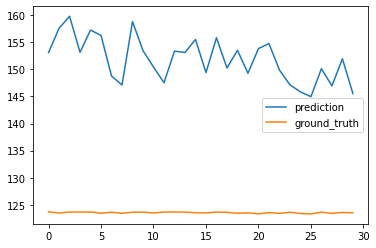

In [20]:
import matplotlib.pyplot as plt
x_truth = []
y_truth = []
x_p = []
y_p = []
p =  y_pred[0,1,:,:2]
x_p = p[:,0]
x_p = x_p.cpu()
x_p = x_p.detach().numpy()
y_p = p[:,1]
print(x_p)
t = out[0,1,:,:2]
x_t = t[:,0]
x_t = x_t.cpu()
x_t = x_t.detach().numpy()
y_t = t[:,1]
plt.plot(range(30),x_p,label= "prediction")
plt.plot(range(30),x_t,label= "ground_truth")
plt.legend()
plt.show()

16090


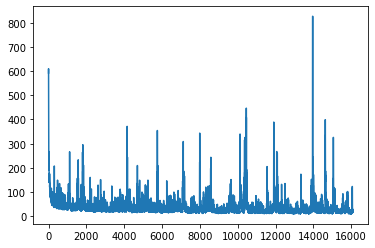

In [21]:
print(len(rmse))
#import matplotlib.pyplot as plt
plt.plot(range(len(rmse)),rmse)
#avrg = rmse / 10020
#plt.plot(range(10020),sum(rmse)/len(rmse))
plt.show()



In [22]:
#Find the index of an agent_id within the track_id of a current scence 
def find_index(track_id, agent_id):
    track_id = list(track_id)
    index = track_id.index(agent_id)
    return index

In [23]:
#   for epoch in range(20):
# y = ["v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8", "v9", "v10", "v11", "v12", "v13", "v14", "v15", "v16", "v17", "v18", "v19", "v20", "v21", "v22", "v23", "v24", "v25", "v26", "v27", "v28", "v29", "v30", "v31", "v32", "v33", "v34", "v35", "v36", "v37", "v38", "v39", "v40", "v41", "v42", "v43", "v44", "v45", "v46", "v47", "v48", "v49", "v50", "v51", "v52", "v53", "v54", "v55", "v56", "v57", "v58", "v59", "v60"]
final_result = []
for i_batch , sample_batch in enumerate(val_loader):
    inp,a_id,t_id,s_id = sample_batch
    
    s_id = list(numpy.concatenate(s_id).flat)
    a_id = list(numpy.concatenate(a_id).flat)
    t_id = numpy.array(t_id)
    
    
    index_list_per_batch = []
    print("SceneIds Length {}".format(len(s_id)))
    print("AgentIds Length {}".format(len(a_id)))
    for i in range(batch_sz):
        flat_t_id = numpy.array(t_id[i])
        print("TrackId Length{}".format(flat_t_id.shape))
        flat_t_id = flat_t_id[:,0,0]
        current_agent_id = a_id[i]
        #print(flat_t_id)
        #print(current_agent_id)
        index = find_index(flat_t_id, current_agent_id)
        #print(index)
        index_list_per_batch.append(index)
    
    #print("AgentId Indexes for all 32 scenes: {} ".format(index_list_per_batch))
    inp = inp.cuda()
        
    
    y_pred = model(inp.reshape((len(inp),-1))).reshape((-1,60,30,4))
    y_pred = y_pred[:,:,:,[0,1]]
    #print("Prediction Tensor Size(32 scenes) {}".format(y_pred.shape))
    
    for i in range(batch_sz):
        row_result = y_pred[i,index_list_per_batch[i],:,:]
        #print("Tensor after i select agent row from  prediction \n {}".format(row_result.shape))
        
        row_result = torch.flatten(row_result)
        #print(row_result)  
        
        
        row_result = row_result.cpu()
        row_result = row_result.detach().numpy()
        row_result = numpy.hstack(([s_id[i]], row_result))
        final_result.append(row_result)
        #ow_result = [s_id[i]] + row_result
        #print(row_result)
        
    
    
    
    
    
    
   
     

SceneIds Length 128
AgentIds Length 128
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1)
TrackId Length(60, 30, 1

In [24]:
print(len(final_result))

3200


In [25]:
# y = ["v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8", "v9", "v10", "v11", "v12", "v13", "v14", "v15", "v16", "v17", "v18", "v19", "v20", "v21", "v22", "v23", "v24", "v25", "v26", "v27", "v28", "v29", "v30", "v31", "v32", "v33", "v34", "v35", "v36", "v37", "v38", "v39", "v40", "v41", "v42", "v43", "v44", "v45", "v46", "v47", "v48", "v49", "v50", "v51", "v52", "v53", "v54", "v55", "v56", "v57", "v58", "v59", "v60"]
final = numpy.array(final_result)
# var = numpy.stack((y, final))
print(final)
#numpy.savetxt("submission.csv", final, delimiter=",")


[[10002.          1707.80383301   338.99752808 ...   362.95602417
   1732.33740234   366.62786865]
 [10015.           724.48919678  1231.34619141 ...  1222.95092773
    719.82226562  1222.67980957]
 [10019.           555.7097168   1252.27709961 ...  1254.03796387
    566.75061035  1252.18261719]
 ...
 [ 9905.          1749.22521973   458.32830811 ...   467.6914978
   1748.6661377    469.09942627]
 [ 9910.           561.38586426  1283.36645508 ...  1283.09802246
    569.83721924  1282.08666992]
 [ 9918.           595.01171875  1161.71228027 ...  1139.515625
    594.57977295  1138.61254883]]


In [26]:

# final.to_csv("Final_Solution")
numpy.savetxt("submission.csv", final, delimiter=",")
